In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Paths to data, plotting and projection export folders
DATA = Path().cwd().parent / 'common_data'
PLOTS = Path.cwd().parent / 'plots'
PROJ = Path().cwd().parent / 'projections'

# Font size of plots
plt.rcParams['font.size'] = 18

# Plot size
FIG_SIZE = (20, 10)

# Building demand in EDGE

In [10]:
HIST_YEARS = list(range(2000, 2021))
PROJ_YEARS = list(range(2020, 2101, 5))

## Import Data

In [14]:
# From shared data
data = pd.read_excel(DATA / 'gdp_pop.xlsx',
                     sheet_name = 'data',
                     usecols = ['year', 'variable', 'unit', 'value'])
data.set_index(['variable', 'year'], inplace = True)
data = data[['value', 'unit']]

# Canada land area in sq. km (from Encyclopedia of World Geography vol 1, McColl)
can_area = 9984670

# GDP from world bank, iiasa (Billion 2005 USD)
gdp_hist = data.loc['gdp_hist'].copy()['value']
gdp_proj = data.loc['gdp_proj'].copy()['value']

# Population from world bank, iiasa (million persons)
pop_hist = data.loc['pop_hist'].copy()['value']
pop_proj = data.loc['pop_proj'].copy()['value']

# Income from world bank, calculated (2005 USD/cap)
income_hist = data.loc['income_hist'].copy()['value']
income_hist = income_hist[HIST_YEARS]
income_proj = data.loc['income_proj'].copy()['value']
income_proj = income_proj[PROJ_YEARS]

# Density calculated (people/sq. km)
density_hist = pop_hist.copy()
density_hist = density_hist*1e6/can_area
density_proj = pop_proj.copy()
density_proj = density_proj*1e6/can_area

## Projections

### Floor Space (m$^2$/cap)

In [21]:
# Timestep function from how_much pp. 516
f_1 = lambda f_0, I_1, I_0, beta, D_1, D_0 : f_0*((I_1/I_0)**beta)*((D_1/D_0)**-0.03)

In [22]:
# Income elasticity starts at 0.42 (table SI4), ends at 0.7*0.42 = 0.294 (table SI5)
income_elasticities = pd.Series(np.linspace(0.42, 0.294, num = len(PROJ_YEARS)), 
                                index = PROJ_YEARS)

In [18]:
# Series to hold demand
floor_demands = pd.Series(np.zeros(len(PROJ_YEARS)),
                          index = PROJ_YEARS)

# Base year floor space demand (parameters from SI4)
alpha = 0.61
beta = 0.42
gamma = -0.03

# Base year formula from how_much pp. 516
floor_2020 = alpha*(income_hist[2020]**beta)*density_hist[2020]**gamma

floor_demands[2020] = floor_2020

In [23]:
# Calculate floorspace demands
for year in PROJ_YEARS[1:]:
    floor_demands[year] = f_1(floor_demands[year-5],
                              income_proj[year],
                              income_proj[year-5],
                              income_elasticities[year], density_proj[year], density_proj[year-5])

In [27]:
# "For levels of income per cap above 20,000 com to res area ratio levels off close to 35%" (how_much pp. 517)
res_floor_demands = floor_demands.copy()
com_floor_demands = res_floor_demands.copy()
com_floor_demands = com_floor_demands*0.35

### Space heating/cooling demand (MJ/cap)

#### HDD/CDD

In [31]:
# HDD and CDD estimates copied roughly from fig. 2 of how_much (pp. 520)
hdd_projection = pd.Series(np.linspace(1200, 725, num = len(PROJ_YEARS)),
                           index = PROJ_YEARS)
cdd_projection = pd.Series(np.linspace(1250, 1800, num = len(PROJ_YEARS)),
                           index = PROJ_YEARS)

In [30]:
# Alternate constant HDD and CDD projection (used for GCAM baseline)
hdd_constant = 4300
cdd_constant = 200

#### U-values

In [38]:
# Calculating insulation values
u_values = pd.Series(np.zeros(len(PROJ_YEARS)),
                     index = PROJ_YEARS)

# Tables SI4 and SI5
gamma = pd.Series(np.linspace(1, 0.7, num = len(PROJ_YEARS)),
                  index = PROJ_YEARS)

# Function found in supp pp. 5, parameters found in SI4
u_func = lambda y, hdd, cdd: y*(0.45 + np.exp(1.4 + (-5e-4)*(hdd+cdd)))

u_values = u_func(gamma, hdd_projection, cdd_projection)

In [44]:
# Formula from how_much pp. 517, parameters from SI4
SH = lambda floorspace, u, hdd: floorspace*u*0.07*hdd

res_sh = pd.Series(np.zeros(len(PROJ_YEARS)),
                   index = PROJ_YEARS)

com_sh = pd.Series(np.zeros(len(PROJ_YEARS)),
                   index = PROJ_YEARS)

res_sh = SH(res_floor_demands, u_values, hdd_projection)
com_sh = SH(com_floor_demands, u_values, hdd_projection)

#### Climate max (for CDD)

In [48]:
# Formulas from how_much pp. 517
cmax = 1-(0.949*np.exp(-0.00187*cdd_projection))

In [55]:
# Formula same as above, parameters from SI4
SC = lambda floorspace, u, cm, cdd, I : floorspace*u*cm*cdd*(0.16/(1 + np.exp((20950 - I)/3774)))

res_sc = pd.Series(np.zeros(len(PROJ_YEARS)),
                   index = PROJ_YEARS)

com_sc = pd.Series(np.zeros(len(PROJ_YEARS)),
                   index = PROJ_YEARS)

res_sc = SC(res_floor_demands, u_values, cmax, cdd_projection, income_proj)
com_sc = SC(com_floor_demands, u_values, cmax, cdd_projection, income_proj)

### Appliances and Lighting (MJ/cap)

In [67]:
# Function from pp. 518, parameters from SI4 (multiplied by 1000000 to convert from TJ to MJ)
appliances = 1e6*np.exp(-7 + 0.3*np.log(income_proj) + (-196/np.sqrt(income_proj)))

### Water heating (MJ/cap)

In [69]:
# Table SI4/5
phi_1 = pd.Series(np.linspace(8.19, 8.19*0.6, num = len(PROJ_YEARS)),
                  index = PROJ_YEARS)

# Function from pp. 518, parameters from SI4,
# multiplied by 1000 to convert from GJ to MJ
water_heating = 1e3*phi_1/(1 + np.exp((24258 - income_proj)/8622))

### Cooking (MJ/cap)

In [71]:
# See section 2.3.4 of how_much
cooking = pd.Series([1.8]*len(PROJ_YEARS),
                    index = PROJ_YEARS)*1e3

## Plotting

### Floor space

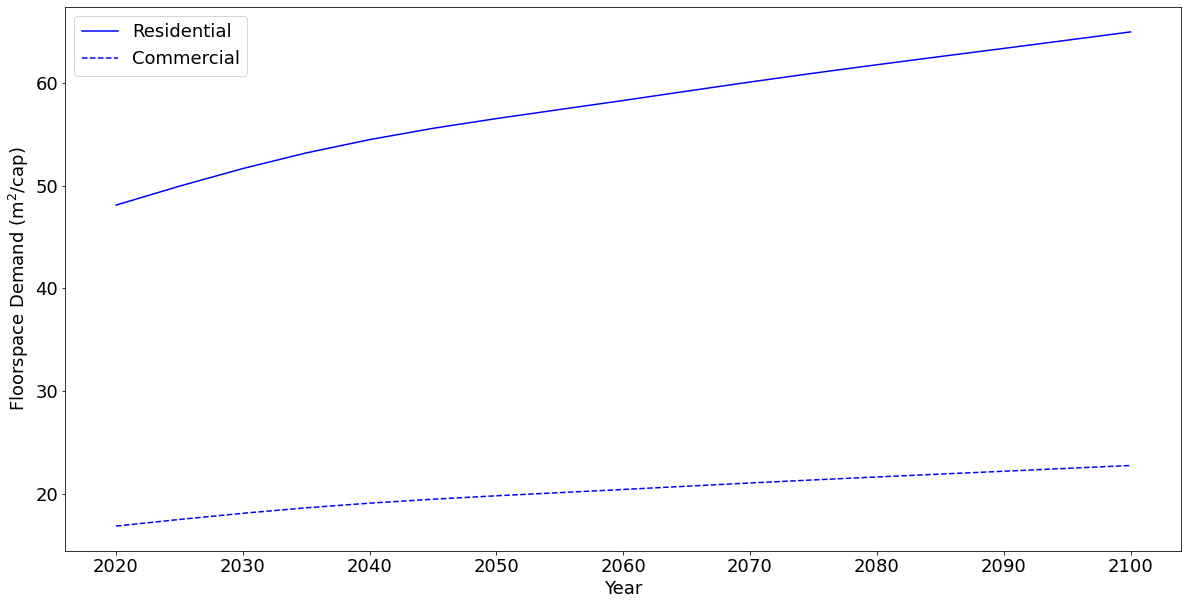

In [29]:
# Floor space
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        res_floor_demands,
        label = 'Residential',
        c = 'blue')
ax.plot(PROJ_YEARS,
        com_floor_demands,
        label = 'Commercial',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Floorspace Demand (m$^2$/cap)');
fig.savefig(PLOTS / 'edge_floorspace_projection.png')

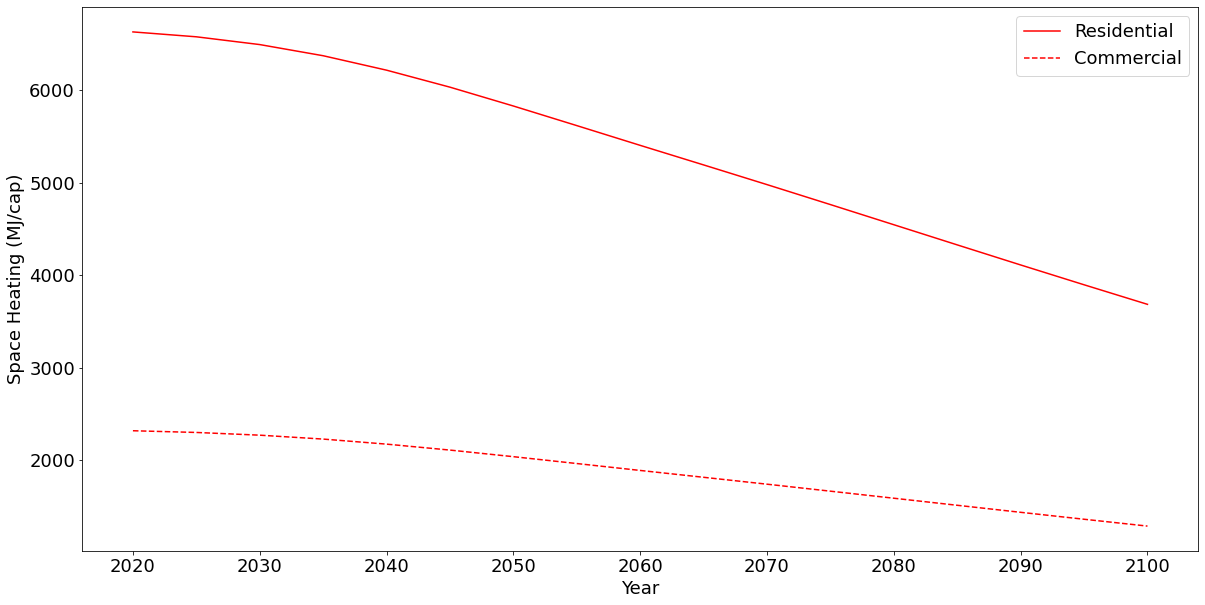

In [47]:
# Space heating
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        res_sh,
        color = 'red',
        label = 'Residential')
ax.plot(PROJ_YEARS,
        com_sh,
        color = 'red',
        ls = '--',
        label = 'Commercial')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Space Heating (MJ/cap)');
fig.savefig(PLOTS / 'edge_space_heating_projection.png')

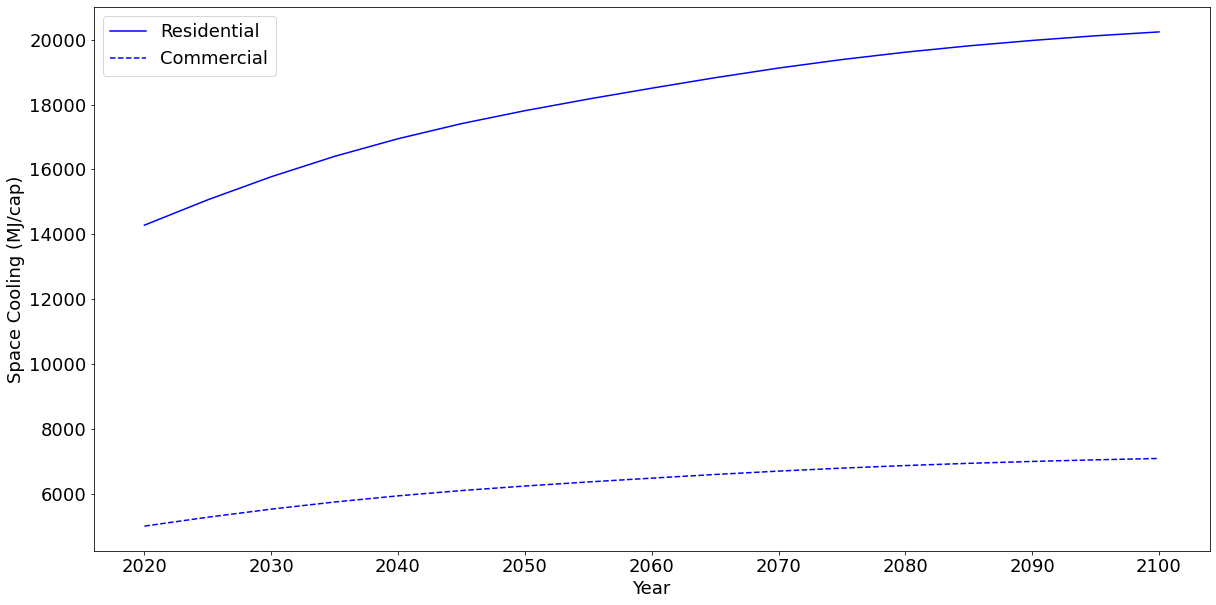

In [58]:
# Space cooling plot
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        res_sc,
        color = 'blue',
        label = 'Residential')
ax.plot(PROJ_YEARS,
        com_sc,
        color = 'blue',
        ls = '--',
        label = 'Commercial')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Space Cooling (MJ/cap)');
fig.savefig(PLOTS / 'edge_space_cooling_projection.png')

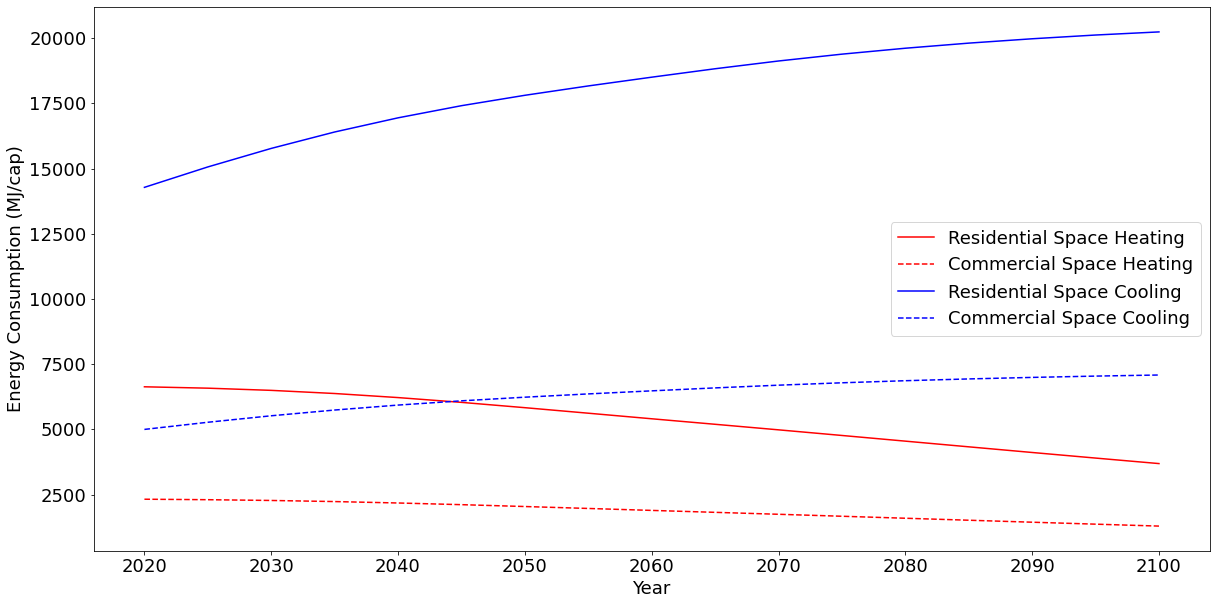

In [60]:
# Space cooling/heating plot
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        res_sh,
        color = 'red',
        label = 'Residential Space Heating')
ax.plot(PROJ_YEARS,
        com_sh,
        color = 'red',
        ls = '--',
        label = 'Commercial Space Heating')
ax.plot(PROJ_YEARS,
        res_sc,
        color = 'blue',
        label = 'Residential Space Cooling')
ax.plot(PROJ_YEARS,
        com_sc,
        color = 'blue',
        ls = '--',
        label = 'Commercial Space Cooling')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Energy Consumption (MJ/cap)');
fig.savefig(PLOTS / 'edge_heating_and_cooling.png')

In [ ]:
# Appliances
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        appliances,
        color = 'green')
ax.set(xlabel = 'Year',
       ylabel = 'Energy Demand (MJ/cap)');

In [ ]:
# Water heating
fig, ax = plt.subplots(figsize = FIG_SIZE)
ax.plot(PROJ_YEARS,
        water_heating,
        color = 'lightblue')
ax.set(xlabel = 'Income (2005 USD/cap)',
       ylabel = 'Energy Demand (MJ/cap)');

In [ ]:
total = water_heating + appliances + cooking + res_sc['value'] + com_sc['value'] + res_sh['value'] + com_sh['value']

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(water_heating,
        income_proj.loc[2020:]['value'],
        color = 'lightblue',
        label = 'Water Heating')
ax.plot(appliances,
        income_proj.loc[2020:]['value'],
        color = 'green',
        label = 'Appliances')
ax.plot(cooking,
        income_proj.loc[2020:]['value'],
        color = 'orange',
        label = 'Cooking')
ax.plot(res_sc['value'],
        income_proj.loc[2020:]['value'],
        color = 'blue',
        label = 'Residential Cooling')
ax.plot(com_sc['value'],
        income_proj.loc[2020:]['value'],
        color = 'blue',
        ls = '--',
        label = 'Commercial Cooling')
ax.plot(res_sh['value'],
        income_proj.loc[2020:]['value'],
        color = 'red',
        label = 'Residential Heating')
ax.plot(com_sh['value'],
        income_proj.loc[2020:]['value'],
        color = 'red',
        ls = '--',
        label = 'Commercial Heating')
# ax.plot(total,
#         income_proj.loc[2020:]['value'],
#         color = 'black',
#         label = 'Total Building Usage')
ax.legend()
ax.set(title = 'EDGE Energy Demand Projection (Canada)',
       xlabel = 'Energy Demand (MJ/cap)',
       ylabel = 'Income (2005 USD/cap)');

### Main figure of interest

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(total,
        gdp_proj.loc[2020:]['value'])
ax.set(xlabel = 'Useful Energy Demand (MJ/cap)',
       ylabel = 'GDP (billion 2005 USD)');

In [ ]:
fig.savefig(PLOTS / 'edge_uec_vs_gdp')

In [ ]:
plt.figure(figsize = (20,20))
plt.rc('font', size = 25)
plt.plot(gdp_projection, useful_energy)
ax = plt.gca()
plt.scatter(gdp_projection, useful_energy)
for i, label in enumerate(proj_years):
    plt.annotate(label, (gdp_projection[i], useful_energy[i]))
plt.ylabel('Useful energy (MJ/cap)')
plt.xlabel('GDP (billion 2005 USD)')
plt.title('EDGE useful energy demand (Canada)')
plt.savefig('edge_useful.jpg')
plt.show()

## Export projections

In [81]:
# Convert projections to dataframes
res_floor = res_floor_demands.to_frame(name = 'value')
res_floor = res_floor.assign(variable = 'res_floor_proj',
                 unit = 'm$^2$/cap')
com_floor = com_floor_demands.to_frame(name = 'value')
com_floor = com_floor.assign(variable = 'com_floor_proj',
                 unit = 'm$^2$/cap')
res_heat = res_sh.to_frame(name = 'value')
res_heat = res_heat.assign(variable = 'res_heat_proj',
                unit = 'MJ/cap')
res_cool = res_sc.to_frame(name = 'value')
res_cool = res_cool.assign(variable = 'res_cool_proj',
                unit = 'MJ/cap')
com_heat = com_sh.to_frame(name = 'value')
com_heat = com_heat.assign(variable = 'com_heat_proj',
                unit = 'MJ/cap')
com_cool = com_sc.to_frame(name = 'value')
com_cool = com_cool.assign(variable = 'com_cool_proj',
                unit = 'MJ/cap')
app = appliances.to_frame(name = 'value')
app = app.assign(variable = 'app_light_proj',
           unit = 'MJ/cap')
wh = water_heating.to_frame(name = 'value')
wh = wh.assign(variable = 'water_heat_proj',
               unit = 'MJ/cap')
cook = cooking.to_frame(name = 'value')
cook = cook.assign(variable = 'cook_proj',
                   unit = 'MJ/cap')

# Create dataframe
proj = pd.concat([res_floor, com_floor, res_heat, res_cool, com_heat, com_cool, app, wh, cook], axis = 0)

In [83]:
# Add model, unit columns
proj = proj.assign(model = 'EDGE')

# Reorder columns
proj = proj[['model', 'variable', 'value', 'unit']]

# Export to csv
proj.to_csv(PROJ / 'edge_building_projections.csv',
           index_label = 'year')

## Final to Useful Conversion (not going to bother with this)

In [ ]:
# Conversion efficiencies
elec_conv = 


In [ ]:
sh_wh_carriers = {'Electricity': 0.4, 'Other Grids': 0.5, 'Liquids/Modern Biomass': 0.1}
sc_carriers = {'Electricity': 0.9, 'Other Grids': 0.1}
app_carriers = {'Electricity': 1}

FE = lambda ue, eff, share : (ue/np.sum(eff*share))

FE_sh = np.zeros(len(proj_years))

# for index in range(0, len(proj_years)):
#     FE_sh[index] = FE(space_heating
